In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import pickle
import sklearn
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier

from collections import defaultdict

import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.weightstats import ttest_ind

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Read data

In [2]:
recs_1 = pd.read_csv("../data/recommendations/recommendations_strat_1_clean.csv").drop("Unnamed: 0", axis=1)
recs_2 = pd.read_csv("../data/recommendations/recommendations_strat_2_clean.csv").drop("Unnamed: 0", axis=1)
recs_3 = pd.read_csv("../data/recommendations/recommendations_strat_3_clean.csv").drop("Unnamed: 0", axis=1)
recs_4 = pd.read_csv("../data/recommendations/recommendations_strat_4_clean.csv").drop("Unnamed: 0", axis=1).dropna()

In [3]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

### Vectorize 

In [4]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

In [5]:
X = x
Y = equal['conspiracy'].values.ravel()

### Train or load model

In [6]:
try:
    svm = pickle.load(open('SVM_trained.sav', 'rb'))
except:
    # Train
    svm = SVC(C=10, kernel="rbf", max_iter = 10000).fit(X, Y)

    # save the model to disk
    pickle.dump(svm, open('SVM_trained.sav', 'wb'))

In [7]:
try:
    mlp = pickle.load(open('MLP_trained.sav', 'rb'))
except:
    mlp = MLPClassifier(hidden_layer_sizes=[10]*10, activation="identity",
                        random_state=0).fit(X, Y)
    
    pickle.dump(mlp, open("MLP_trained.sav", 'wb'))

### Transform recommendations to tf-idf

In [8]:
recs_tfidf_1 = v.transform(recs_1["full_text"].values)
recs_tfidf_2 = v.transform(recs_2["full_text"].values)
recs_tfidf_3 = v.transform(recs_3["full_text"].values)
recs_tfidf_4 = v.transform(recs_4["full_text"].values)

### Predictions

In [22]:
try:
    combined = pd.read_csv("predicted.csv")
except:    
    recs_1["conspiracy_pred"] = svm.predict(recs_tfidf_1)
    recs_2["conspiracy_pred"] = svm.predict(recs_tfidf_2)
    recs_3["conspiracy_pred"] = svm.predict(recs_tfidf_3)
    recs_4["conspiracy_pred"] = svm.predict(recs_tfidf_4)
    
    recs_1["strategy"] = "strategy 1"
    recs_2["strategy"] = "strategy 2"
    recs_3["strategy"] = "strategy 3"
    recs_4["strategy"] = "strategy 4"
    
    combined = pd.concat([recs_1, recs_2, recs_3, recs_4], ignore_index=True)
    
    combined.to_csv("predicted.csv")

## Aggregates

In [23]:
# Select useful columns
combined = combined[["user", "strategy", "vids_watched",
                     "views", "likes", "dislikes",
                     "duration", "full_text", "conspiracy_pred"]].copy()

In [11]:
def to_seconds(duration):
    times = re.findall("\d+", duration)[::-1]
    return sum([int(times[i]) * 60**i for i in range(len(times))])

In [12]:
# Convert time to seconds
combined["duration"] = combined["duration"].apply(lambda x: to_seconds(str(x)))

In [13]:
# Group
grouped = combined.groupby(["strategy", "vids_watched"])

## Pivot and plot

In [14]:
sns.set_theme(style="whitegrid")

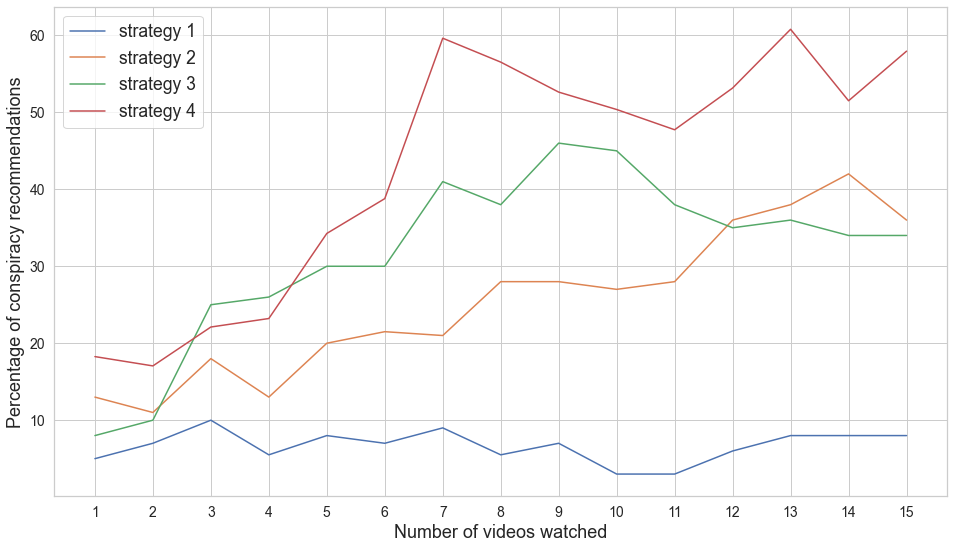

In [16]:
# Pivot
pivot = pd.pivot_table(combined,
                       index = ("strategy", "user"),
                       columns = "vids_watched",
                       values = "conspiracy_pred",
                       aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot = (pivot.fillna(method="ffill", axis = 1) + pivot.fillna(method="bfill", axis = 1)) / 2 

grouped = pivot.groupby("strategy").mean()

# Plot
plt.figure(figsize=(16,9))

x = grouped.columns
y = grouped.values * 100
labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

for y_val, label in zip(y, labels):
    plt.plot(x, y_val, label=label);

plt.xticks(np.arange(1, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})
plt.savefig('conspiracy_recs.pdf')

### Split strategy into individual users

<AxesSubplot:xlabel='vids_watched'>

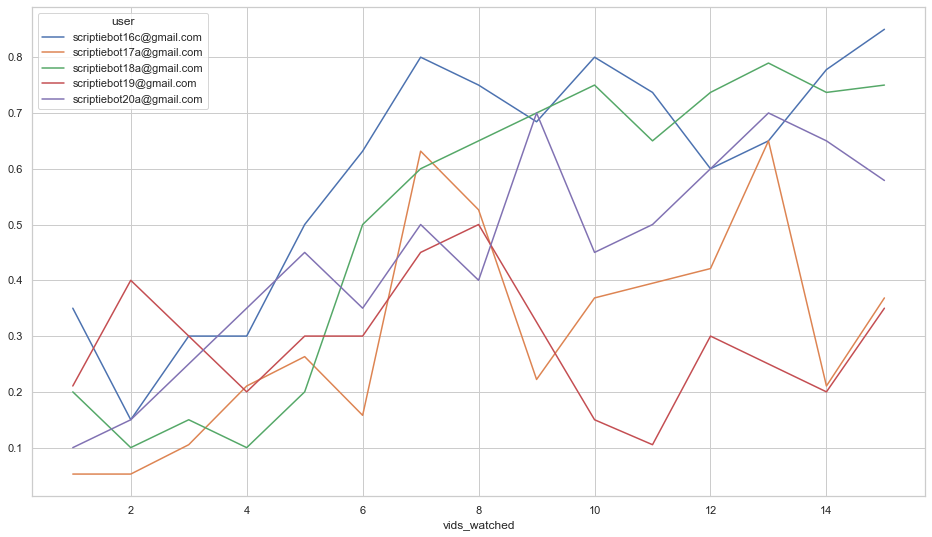

In [17]:
pivot.loc["strategy 4"].T.plot(figsize=(16,9))

## Significance testing

In [18]:
def group(combined, strategy, i):
    return combined[(combined["strategy"] == strategy) & 
                    (combined["vids_watched"] == i)].groupby("user")["conspiracy_pred"].mean().values

In [19]:
results = defaultdict(dict)
sigs = defaultdict(list)

for strategy in ["strategy 2", "strategy 3", "strategy 4"]:
    for i in range(1, 16):
        x = group(combined, "strategy 1", i)
        
        y = group(combined, strategy, i)
        results[strategy][i] = ttest_ind(x, y, alternative="smaller")[1]
    
for strat in results:
    for vid in results[strat]:
        if results[strat][vid] <= 0.001:
            sigs[strat].append("***")
        elif results[strat][vid] <= 0.01:
            sigs[strat].append("**")
        elif results[strat][vid] <= 0.05:
            sigs[strat].append("*")
        else:
            sigs[strat].append("")
            
sigs

defaultdict(list,
            {'strategy 2': ['**',
              '',
              '',
              '',
              '',
              '**',
              '*',
              '***',
              '***',
              '***',
              '**',
              '***',
              '***',
              '***',
              '***'],
             'strategy 3': ['',
              '',
              '*',
              '**',
              '***',
              '**',
              '*',
              '*',
              '**',
              '***',
              '***',
              '***',
              '**',
              '***',
              '***'],
             'strategy 4': ['*',
              '',
              '',
              '*',
              '**',
              '**',
              '***',
              '***',
              '**',
              '**',
              '**',
              '***',
              '***',
              '**',
              '***']})

## Plotting significance

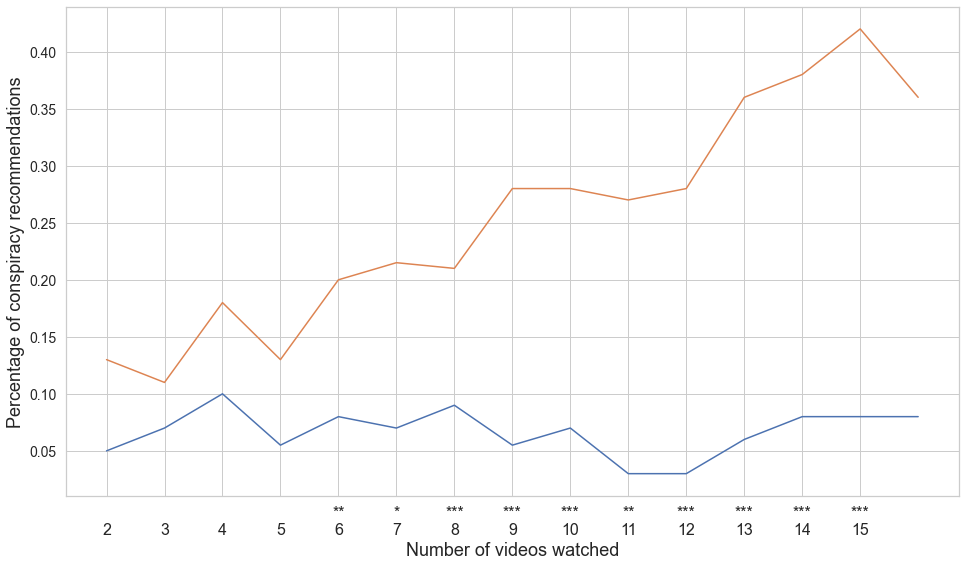

In [20]:
labels_1 = [sigs["strategy 2"][i-1] + "\n" + str(i) for i in range(1, 16, 1)]

plt.figure(figsize=(16,9))

plt.xticks(range(len(labels_1)), labels_1, fontsize=16)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.plot(pivot.groupby("strategy").mean().loc[["strategy 1", "strategy 2"]].T);

# Similarity measures

In [24]:
similarities = combined.groupby(["strategy", 
                                 "vids_watched"])["full_text"].apply(lambda x: 
                                                                     cosine_similarity(v.transform(x)))

In [48]:
similarities.loc["strategy 1"][1][0]
# ax[1, 0].plot(pivot.groupby("strategy").mean().loc[["strategy 1", "strategy 2"]].T);
# ax[1, 1].plot(pivot.groupby("strategy").mean().loc[["strategy 1", "strategy 4"]].T);

# plt.ylabel("Average similarity between recommendations", fontsize=18);
# plt.xlabel("Number of videos watched", fontsize=18);

# plt.xticks(np.arange(1, 16, 1), fontsize=14);
# plt.yticks(fontsize=14);

# plt.legend(loc="upper left", prop = {"size": 17.5});

array([1.00000000e+00, 2.82599576e-03, 4.71334621e-03, 6.00555983e-03,
       0.00000000e+00, 1.58221036e-03, 7.14955261e-03, 9.78853169e-03,
       2.17718072e-02, 0.00000000e+00, 0.00000000e+00, 3.03949784e-03,
       1.49435022e-02, 4.43020716e-03, 4.37299041e-03, 1.02118766e-02,
       2.80162471e-03, 2.15777055e-03, 8.19629216e-03, 0.00000000e+00,
       5.89889818e-03, 2.56733098e-03, 1.03046697e-02, 0.00000000e+00,
       4.36497334e-03, 7.07446403e-04, 7.43110170e-03, 5.60228761e-03,
       3.63571306e-03, 5.98762606e-03, 9.27678882e-03, 1.49435022e-02,
       4.43020716e-03, 4.37299041e-03, 3.05282663e-03, 1.58610597e-01,
       7.65682508e-03, 5.03729399e-03, 3.20950126e-03, 7.96317606e-03,
       1.41371943e-03, 0.00000000e+00, 7.06939139e-03, 2.86092634e-03,
       7.67089797e-03, 5.54880762e-03, 1.04618275e-02, 2.09586888e-03,
       3.45605729e-03, 4.47091978e-03, 5.00687936e-03, 1.49435022e-02,
       4.43020716e-03, 4.37299041e-03, 1.07090240e-03, 6.58840662e-03,
      

# Experiment 2 results

In [52]:
recs_22 = pd.read_csv("../data/recommendations/recommendations_strat_2_exp_2_clean.csv").drop("Unnamed: 0", axis = 1)

In [53]:
recs_tfidf_22 = v.transform(recs_22["full_text"].values)
recs_22["conspiracy_pred"] = svm.predict(recs_tfidf_22)

In [54]:
recs_22["duration"] = recs_22["duration"].apply(lambda x: to_seconds(str(x)))

No handles with labels found to put in legend.


<AxesSubplot:xlabel='vids_watched', ylabel='Percentage of conspiracy recommendations'>

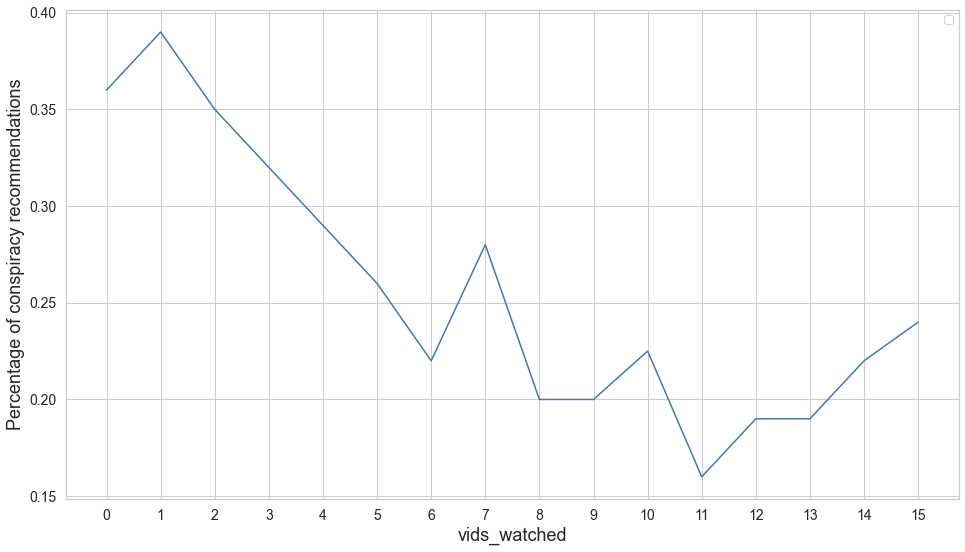

In [74]:
# Pivot
pivot_2 = pd.pivot_table(recs_22,
                       index = "user",
                       columns = "vids_watched",
                       values = "conspiracy_pred",
                       aggfunc = np.mean)

# Fill na with average of previous and next cell in column
pivot_2 = (pivot_2.fillna(method="ffill", axis = 1) + pivot_2.fillna(method="bfill", axis = 1)) / 2 

# grouped_2 = pivot_2.groupby("strategy").mean()

# Plot
plt.figure(figsize=(16,9))

#x = grouped_2.columns
#y = grouped_2.values * 100
#labels = ["strategy 1", "strategy 2", "strategy 3", "strategy 4"]

#for y_val, label in zip(y, labels):
#    plt.plot(x, y_val, label=label);

plt.xticks(np.arange(0, 16, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Number of videos watched", fontsize=18);
plt.ylabel("Percentage of conspiracy recommendations", fontsize=18);

plt.legend(loc="upper left", prop = {"size": 17.5})

#grouped_2.plot()
#plt.savefig('conspiracy_recs.pdf')
yeet = pivot_2.mean(axis=0)
yeet.loc[0] = pivot.loc["strategy 2"][15].mean()

yeet.sort_index().plot()